In [2]:
import numpy as np
import matplotlib.pyplot as plt
import vutils
%matplotlib inline
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss
import seaborn as sns
import warnings
warnings.catch_warnings()
warnings.simplefilter("ignore")
import lightning as L
from torchvision import datasets
import torch
from torch import nn
from torchvision.transforms import ToTensor,Lambda
from torchvision import transforms
from torchmetrics import Accuracy
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader, random_split
from torchvision.io import read_image
import pandas as pd
import tensorflow as tf
from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader
from torch import nn
import neptune.new as neptune
from neptune.new.integrations.pytorch_lightning import NeptuneLogger
from sklearn.metrics import auc, precision_recall_curve
import pytorch_lightning as pl
from sklearn.model_selection import StratifiedKFold
# import pytorch_lightning as pl
import os
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.cuda.empty_cache()

In [6]:
test_data_path = 'archive/test'
# train_path = 'C:\\Users\\nadav\\PycharmProjects\\assignment1\\pythonProject7\\archive\\asl_alphabet_subset'
train_path = 'C:\\Users\\nadav\\Downloads\\Final_Data_Full\\Final_Data_Full\\train'

label_mapping = {
        'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9,
        'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18,
        'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26,
        'nothing': 27, 'space': 28, 'five': 29
    } 
inverted_label_mapping = {v: k for k, v in label_mapping.items()}

In [7]:
batch_size = 64
data_path = './data_folder/'

class CNN_ASL(pl.LightningModule):
    def __init__(self, train_data, val_data, data_dir=data_path, num_classes=29, learning_rate=2e-4, batch_size=batch_size):
        super().__init__()
        
        self.run = neptune.init_run(
        project="nadavcherry/dp1",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIyNTVhYzkxZC1jOTc3LTQ4ZjYtOGFhZC00MzljZmVlOGFhYWEifQ==", # your credentials
        )

        # Set our init args as class attributes
        self.transform = transforms.Compose(
            [
                transforms.Resize((200, 200)),
                # transforms.Grayscale(num_output_channels=1),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

            ]
        )

        
        self.asl_test = datasets.ImageFolder(test_data_path, transform=transform)
        self.asl_train = train_data
        self.asl_val = val_data
        self.data_dir = data_dir
        self.learning_rate = learning_rate
        self.batch_size=batch_size
        self.y = []
        self.preds = []
        # Hardcode some dataset specific attributes
        self.num_classes = num_classes
        
        ## input channels 1 - monochrom (for rgb would be 3)
        ## output channels 32 - as the number of filters that we train
        ## kernel size 3 - arbitrary selection
        self.conv_11 = nn.Conv2d(1,16,11, padding='same')
        self.conv_7 = nn.Conv2d(16,32,7, padding='same')
        self.conv1 = nn.Conv2d(32,64,3,padding='same') 
        ## input channels 1 - monochrom (for rgb would be 3)
        ## output channels 32 - as the number of filters that we train
        ## kernel size 3 - arbitrary selection
        # self.conv1 = nn.Conv2d(1,32,3,padding='same')
        self.conv_11 = nn.Conv2d(1,16,11, padding='same')
        self.conv_7 = nn.Conv2d(16,32,7, padding='same')
        self.conv1 = nn.Conv2d(32,64,3,padding='same') 
        self.conv2 = nn.Conv2d(64,128,3,padding='same')
        self.conv3 = nn.Conv2d(128,64,3,padding='same')
        self.conv4 = nn.Conv2d(64,64,3,padding='same')
        self.linear1 = nn.Linear(25*25*64,50)
        self.linear2 = nn.Linear(50,self.num_classes)
        self.mp = nn.MaxPool2d(2,2)
        self.relu=nn.ReLU()
        self.val_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.train_accuracy = Accuracy(task="multiclass", num_classes=num_classes)

        self.count_batch_train = 0
        self.count_batch_val = 0
        self.count_batch_test = 0
        self.train_loss1 = 0
        self.train_accuracy1 = 0

        self.val_loss1 = 0
        self.val_accuracy1 = 0

        self.test_loss1 = 0
        self.test_accuracy1 = 0
        
        self.val_loss_arr = []
        self.val_accuracy_arr = []
        
        self.count_good_high_confidence = 0
        self.count_good_classification_uncertain_confidence = 0
        self.count_bad_classification = 0

    def forward(self, x):
        x = self.relu(self.conv_11(x))
        x = self.relu(self.conv_7(x))
        x = self.mp(x)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.mp(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.mp(x)
        x = x.view(-1,25*25*64) ### WHY -1
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return F.log_softmax(x,dim=1)

        
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = self.train_accuracy(preds, y)
        acc1 = acc.item()
        loss1 = loss.item()
        self.train_accuracy1 += acc1
        self.train_loss1 += loss1
        self.count_batch_train += 1
        self.run["train/accuracy_batch"].log(acc1)
        self.run["train/loss_batch"].log(loss1)
        return loss
    
    def on_train_epoch_end(self):
        self.run["train/accuracy_epochs"].log(self.train_accuracy1/self.count_batch_train)
        self.run["train/loss_epochs"].log(self.train_loss1/self.count_batch_train)
        self.train_accuracy1 = 0
        self.train_loss1 = 0
        self.count_batch_train = 0

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = self.val_accuracy(preds, y)
        acc1 = acc.item()
        loss1 = loss.item()
        self.val_accuracy1 += acc1
        self.val_loss1 += loss1
        self.count_batch_val += 1
        self.run["val/accuracy_batch"].log(acc1)
        self.run["val/loss_batch"].log(loss1)
        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val/val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val/val_acc", self.val_accuracy, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        val_acc = self.val_accuracy1/self.count_batch_val
        val_loss_temp = self.val_loss1/self.count_batch_val
        self.run["val/accuracy_epochs"].log(val_acc)
        self.run["val/loss_epochs"].log(val_loss_temp)
        
        self.val_loss_arr.append(val_loss_temp)
        self.val_accuracy_arr.append(val_acc)
        
        self.val_accuracy1 = 0
        self.val_loss1 = 0
        self.count_batch_val = 0

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        logits = logits.cpu()
        y = y.cpu()
        preds = torch.argmax(logits, dim=1)
       # Compute softmax probabilities
        probs = F.softmax(logits, dim=1)
        acc = self.test_accuracy(preds, y)
        self.test_accuracy1 += acc.item()
        self.test_loss1 += loss.item()
        self.count_batch_test += 1
        self.count_good_high_confidence = 0
        self.count_good_classification_uncertain_confidence = 0
        transform1 = transforms.ToPILImage()
        for i in range(len(y)):    
            self.y.append(y[i])
            self.preds.append(preds[i])
            if y[i] == preds[i]:
                if probs[i, preds[i]] > 0.95:  # High confidence good classification
                    if self.count_good_high_confidence == 2:
                        continue
                    self.count_good_high_confidence += 1
                    img_path = f"images/example_good_high_confidence_{batch_idx}_{i}.png"                
                    transform1(x[i]).save(img_path)
                    self.run[f"Good classification High confidence/true label: {inverted_label_mapping[y[i].item()]}, prediction: {inverted_label_mapping[preds[i].item()]}, probabilities: {probs[i, preds[i]]}, Batch_id: {batch_idx}, Example: {i}"].upload(img_path)
                    # display(transform1(x[i]))
                elif probs[i, preds[i]] < 0.4:  # Uncertain classification
                    if self.count_good_classification_uncertain_confidence == 2:
                        continue
                    self.count_good_classification_uncertain_confidence += 1
                    img_path = f"images/Uncertain_confidence_{batch_idx}_{i}.png"
                    transform1(x[i]).save(img_path)
                    self.run[f"Good classification Uncertain classification/true label: {inverted_label_mapping[y[i].item()]}, prediction: {inverted_label_mapping[preds[i].item()]}, probabilities: {probs[i, preds[i]]}, Batch_id: {batch_idx}, Example: {i}"].upload(img_path)
            elif probs[i, preds[i]] > 0.4:
                self.count_bad_classification += 1
                # if self.count_bad_classification > 100:
                #     continue
                img_path = f"images/Bad_classification_{batch_idx}_{i}.png"
                transform1(x[i]).save(img_path)
                self.run[f"Bad_classification/true label: {inverted_label_mapping[y[i].item()]}, prediction: {inverted_label_mapping[preds[i].item()]}, probabilities: {probs[i, preds[i]]}, Batch_id: {batch_idx}, Example: {i}"].upload(img_path)
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_acc", self.test_accuracy, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def on_test_end(self):
        cm = confusion_matrix(self.y, self.preds)
            
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, cmap='Greens', annot=True, fmt='d')
        plt.xlabel('Prediction')
        plt.ylabel('True label')
        plt.title('ASL Convolutional Model\nClassification Results on Test Set')
        
        # Save the confusion matrix plot
        cm_plot_path = 'confusion_matrix_plot.png'
        plt.savefig(cm_plot_path)
        plt.close()

        
        folder_path = "lightning_logs"
        version = os.listdir(folder_path)[-1] + '/checkpoints'
        file_path = os.listdir(folder_path+'/'+version)
        f = str(folder_path+'/'+version+'/'+file_path[0])
        self.run[f'Confusion_Matrix_Plot'].upload(cm_plot_path)
        self.run["test_accuracy"] = (self.test_accuracy1/self.count_batch_test)
        self.run["test_loss"] = (self.test_loss1/self.count_batch_test)
        self.run[f"{file_path[0]}"].upload(f)    
        self.run.stop()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


    def train_dataloader(self):
        return self.asl_train

    def val_dataloader(self):
        return self.asl_val

    def test_dataloader(self):
        return DataLoader(self.asl_test, batch_size=self.batch_size)


In [8]:
transform = transforms.Compose(
    [
        transforms.Resize((200, 200)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)
train_dataset = datasets.ImageFolder(train_path, transform=transform)
dataset_size = len(train_dataset)
train_size = int(dataset_size * 0.8)
val_size = dataset_size - train_size
train_data, train_val = random_split(train_dataset, [train_size, val_size])
train_loader  = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(train_val, batch_size=batch_size)
# 
kf_model = CNN_ASL(train_loader, val_loader, num_classes=30)
# Define EarlyStopping callback
early_stop_callback = EarlyStopping(
    monitor='val/val_loss',  # Metric to monitor for improvement
    min_delta=0.001,      # Minimum change in the monitored metric to qualify as improvement
    patience=3,           # Number of epochs with no improvement after which training will be stopped
    verbose=True,         # Print message when training is stopped due to early stopping
    mode='min'            # 'min' or 'max': whether the monitored metric should be minimized or maximized
)

# Initialize Trainer with EarlyStopping callback
trainer = pl.Trainer(
    accelerator="auto",
    max_epochs=50,
    callbacks=[early_stop_callback]  # Pass the EarlyStopping callback to the Trainer
)
trainer.fit(kf_model)
# # 
# # 
# # # 
# # # model = CNN_ASL.load_from_checkpoint("lightning_logs/version_181/checkpoints/epoch=19-step=19580.ckpt",train_data=train_data, val_data=train_val)
# # # # model = CNN_ASL.load_from_checkpoint("lightning_logs/version_283/checkpoints/epoch=4-step=95.ckpt", train_data=train_data, val_data=train_val)
# # # # disable randomness, dropout, etc...
# # # model.eval()

https://app.neptune.ai/nadavcherry/dp1/e/DP-266
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type               | Params
-------------------------------------------------------
0  | conv_11        | Conv2d             | 2.0 K 
1  | conv_7         | Conv2d             | 25.1 K
2  | conv1          | Conv2d             | 18.5 K
3  | conv2          | Conv2d             | 73.9 K
4  | conv3          | Conv2d             | 73.8 K
5  | conv4          | Conv2d             | 36.9 K
6  | linear1        | Li

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved. New best score: 1.191


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.553 >= min_delta = 0.001. New best score: 0.638


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.106 >= min_delta = 0.001. New best score: 0.532


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.091 >= min_delta = 0.001. New best score: 0.442


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.039 >= min_delta = 0.001. New best score: 0.403


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/val_loss did not improve in the last 3 records. Best score: 0.403. Signaling Trainer to stop.


In [9]:
trainer.test(kf_model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 923 operations to synchronize with Neptune. Do not kill this process.
Still waiting for the remaining 707 operations (23.40% done). Please wait.
Still waiting for the remaining 707 operations (23.40% done). Please wait.
Still waiting for the remaining 707 operations (23.40% done). Please wait.
All 923 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/nadavcherry/dp1/e/DP-266
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9239093661308289
        test_loss           0.44822049140930176
─────────────────────────────────────────────────────────────────────────────────────────────────────

[{'test_loss': 0.44822049140930176, 'test_acc': 0.9239093661308289}]

In [7]:
transform = transforms.Compose(
    [
        transforms.Resize((200, 200)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [8]:
train_dataset = datasets.ImageFolder(train_path, transform=transform)

In [9]:
max_acc = 0
fold_num = 5
ensemble_models = []
test_accuracy = []
test_loss = []
val_accuracy = []
val_loss = []
kf = StratifiedKFold(n_splits=fold_num, shuffle=True)
for i, (train_index, val_index) in enumerate(kf.split(train_dataset,train_dataset.targets)):



    train_subset = torch.utils.data.Subset(train_dataset, train_index)
    val_subset = torch.utils.data.Subset(train_dataset, val_index)

    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size,shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=True)

    kf_model = CNN_ASL(train_loader, val_loader, num_classes=30)
    # Define EarlyStopping callback
    early_stop_callback = EarlyStopping(
        monitor='val/val_loss',  # Metric to monitor for improvement
        min_delta=0.001,      # Minimum change in the monitored metric to qualify as improvement
        patience=3,           # Number of epochs with no improvement after which training will be stopped
        verbose=True,         # Print message when training is stopped due to early stopping
        mode='min'            # 'min' or 'max': whether the monitored metric should be minimized or maximized
    )

    # Initialize Trainer with EarlyStopping callback
    trainer = pl.Trainer(
        accelerator="auto",
        max_epochs=50,
        callbacks=[early_stop_callback]  # Pass the EarlyStopping callback to the Trainer
    )
    trainer.fit(kf_model)
    trainer.test(kf_model)

    ensemble_models.append(kf_model)
    # Calculate test accuracy and test loss

    test_accuracy.append(kf_model.test_accuracy1/kf_model.count_batch_test)
    test_loss.append(kf_model.test_loss1/kf_model.count_batch_test)
    val_accuracy.append(kf_model.val_accuracy_arr)
    val_loss.append(kf_model.val_loss_arr)



https://app.neptune.ai/nadavcherry/dp1/e/DP-260
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type               | Params
-------------------------------------------------------
0  | conv1          | Conv2d             | 320   
1  | conv2          | Conv2d             | 18.5 K
2  | conv3          | Conv2d             | 18.5 K
3  | conv4          | Conv2d             | 18.5 K
4  | linear1        | Linear             | 8.0 M 
5  | linear2        | Linear             | 1.5 K 
6  | mp             | Ma

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved. New best score: 1.103


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.504 >= min_delta = 0.001. New best score: 0.599


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.098 >= min_delta = 0.001. New best score: 0.501


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.037 >= min_delta = 0.001. New best score: 0.463


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/val_loss did not improve in the last 3 records. Best score: 0.463. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 896 operations to synchronize with Neptune. Do not kill this process.
Still waiting for the remaining 896 operations (0.00% done). Please wait.
Still waiting for the remaining 896 operations (0.00% done). Please wait.
Still waiting for the remaining 896 operations (0.00% done). Please wait.
Still waiting for the remaining 896 operations (0.00% done). Please wait.
All 896 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/nadavcherry/dp1/e/DP-260
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9138766527175903
        test_loss           0.44320744276046753
──────────────────────────────

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type               | Params
-------------------------------------------------------
0  | conv1          | Conv2d             | 320   
1  | conv2          | Conv2d             | 18.5 K
2  | conv3          | Conv2d             | 18.5 K
3  | conv4          | Conv2d             | 18.5 K
4  | linear1        | Linear             | 8.0 M 
5  | linear2        | Linear             | 1.5 K 
6  | mp             | MaxPool2d          | 0     
7  | relu           | ReLU               | 0     
8  | val_accuracy   | MulticlassAccuracy | 0     
9  | test_accuracy  | MulticlassAccuracy | 0     
10 | train_accuracy | MulticlassAccuracy | 0     
-------------------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.229    To

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved. New best score: 1.588


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.550 >= min_delta = 0.001. New best score: 1.038


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.191 >= min_delta = 0.001. New best score: 0.847


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.102 >= min_delta = 0.001. New best score: 0.745


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.077 >= min_delta = 0.001. New best score: 0.667


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.059 >= min_delta = 0.001. New best score: 0.609


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.015 >= min_delta = 0.001. New best score: 0.594


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.589


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/val_loss did not improve in the last 3 records. Best score: 0.589. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1232 operations to synchronize with Neptune. Do not kill this process.
Still waiting for the remaining 1232 operations (0.00% done). Please wait.
Still waiting for the remaining 900 operations (26.95% done). Please wait.
Still waiting for the remaining 900 operations (26.95% done). Please wait.
Still waiting for the remaining 900 operations (26.95% done). Please wait.
Still waiting for the remaining 900 operations (26.95% done). Please wait.
All 1232 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/nadavcherry/dp1/e/DP-261
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.86303687095642

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type               | Params
-------------------------------------------------------
0  | conv1          | Conv2d             | 320   
1  | conv2          | Conv2d             | 18.5 K
2  | conv3          | Conv2d             | 18.5 K
3  | conv4          | Conv2d             | 18.5 K
4  | linear1        | Linear             | 8.0 M 
5  | linear2        | Linear             | 1.5 K 
6  | mp             | MaxPool2d          | 0     
7  | relu           | ReLU               | 0     
8  | val_accuracy   | MulticlassAccuracy | 0     
9  | test_accuracy  | MulticlassAccuracy | 0     
10 | train_accuracy | MulticlassAccuracy | 0     
-------------------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.229    To

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved. New best score: 1.580


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.540 >= min_delta = 0.001. New best score: 1.040


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.209 >= min_delta = 0.001. New best score: 0.831


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.139 >= min_delta = 0.001. New best score: 0.692


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.045 >= min_delta = 0.001. New best score: 0.647


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.078 >= min_delta = 0.001. New best score: 0.569


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.559


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.043 >= min_delta = 0.001. New best score: 0.516


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/val_loss did not improve in the last 3 records. Best score: 0.516. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1162 operations to synchronize with Neptune. Do not kill this process.
Still waiting for the remaining 920 operations (20.83% done). Please wait.
Still waiting for the remaining 920 operations (20.83% done). Please wait.
Still waiting for the remaining 920 operations (20.83% done). Please wait.
Still waiting for the remaining 920 operations (20.83% done). Please wait.
Still waiting for the remaining 920 operations (20.83% done). Please wait.
All 1162 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/nadavcherry/dp1/e/DP-262
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.89076769351959

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type               | Params
-------------------------------------------------------
0  | conv1          | Conv2d             | 320   
1  | conv2          | Conv2d             | 18.5 K
2  | conv3          | Conv2d             | 18.5 K
3  | conv4          | Conv2d             | 18.5 K
4  | linear1        | Linear             | 8.0 M 
5  | linear2        | Linear             | 1.5 K 
6  | mp             | MaxPool2d          | 0     
7  | relu           | ReLU               | 0     
8  | val_accuracy   | MulticlassAccuracy | 0     
9  | test_accuracy  | MulticlassAccuracy | 0     
10 | train_accuracy | MulticlassAccuracy | 0     
-------------------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.229    To

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved. New best score: 1.896


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.646 >= min_delta = 0.001. New best score: 1.251


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.266 >= min_delta = 0.001. New best score: 0.985


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.046 >= min_delta = 0.001. New best score: 0.940


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.160 >= min_delta = 0.001. New best score: 0.779


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.025 >= min_delta = 0.001. New best score: 0.754


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.071 >= min_delta = 0.001. New best score: 0.683


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.673


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.042 >= min_delta = 0.001. New best score: 0.623


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.622


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/val_loss did not improve in the last 3 records. Best score: 0.622. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1120 operations to synchronize with Neptune. Do not kill this process.
Still waiting for the remaining 880 operations (21.43% done). Please wait.
Still waiting for the remaining 880 operations (21.43% done). Please wait.
Still waiting for the remaining 880 operations (21.43% done). Please wait.
Still waiting for the remaining 880 operations (21.43% done). Please wait.
All 1120 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/nadavcherry/dp1/e/DP-263
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.862022340297699
        test_loss           0.5905736088752747
─────────────────────────

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type               | Params
-------------------------------------------------------
0  | conv1          | Conv2d             | 320   
1  | conv2          | Conv2d             | 18.5 K
2  | conv3          | Conv2d             | 18.5 K
3  | conv4          | Conv2d             | 18.5 K
4  | linear1        | Linear             | 8.0 M 
5  | linear2        | Linear             | 1.5 K 
6  | mp             | MaxPool2d          | 0     
7  | relu           | ReLU               | 0     
8  | val_accuracy   | MulticlassAccuracy | 0     
9  | test_accuracy  | MulticlassAccuracy | 0     
10 | train_accuracy | MulticlassAccuracy | 0     
-------------------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.229    To

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved. New best score: 1.691


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.556 >= min_delta = 0.001. New best score: 1.134


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.199 >= min_delta = 0.001. New best score: 0.936


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.108 >= min_delta = 0.001. New best score: 0.828


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.073 >= min_delta = 0.001. New best score: 0.755


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.025 >= min_delta = 0.001. New best score: 0.730


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.026 >= min_delta = 0.001. New best score: 0.704


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.017 >= min_delta = 0.001. New best score: 0.687


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.016 >= min_delta = 0.001. New best score: 0.671


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.662


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/val_loss improved by 0.032 >= min_delta = 0.001. New best score: 0.630


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/val_loss did not improve in the last 3 records. Best score: 0.630. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 966 operations to synchronize with Neptune. Do not kill this process.
Still waiting for the remaining 966 operations (0.00% done). Please wait.
Still waiting for the remaining 966 operations (0.00% done). Please wait.
Still waiting for the remaining 966 operations (0.00% done). Please wait.
Still waiting for the remaining 128 operations (86.75% done). Please wait.
All 966 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/nadavcherry/dp1/e/DP-264
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8471423983573914
        test_loss            0.684205949306488
──────────────────────────────

In [14]:
kf_model

CNN_ASL(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (linear1): Linear(in_features=160000, out_features=50, bias=True)
  (linear2): Linear(in_features=50, out_features=29, bias=True)
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (train_accuracy): MulticlassAccuracy()
)

In [18]:
# ensemble_models.append(kf_model)
# Calculate test accuracy and test loss
test_accuracy = []
test_loss = []
val_accuracy = []
val_loss = []
for i in range(5):
    kf_model = ensemble_models[i]
    test_accuracy.append(kf_model.test_accuracy1/kf_model.count_batch_test)
    test_loss.append(kf_model.test_loss1/kf_model.count_batch_test)

In [10]:
print(len(val_accuracy[0]))
print(len(val_accuracy[1]))
print(len(val_accuracy[2]))
print(len(val_accuracy[3]))
print(len(val_accuracy[4]))

8
13
13
16
16


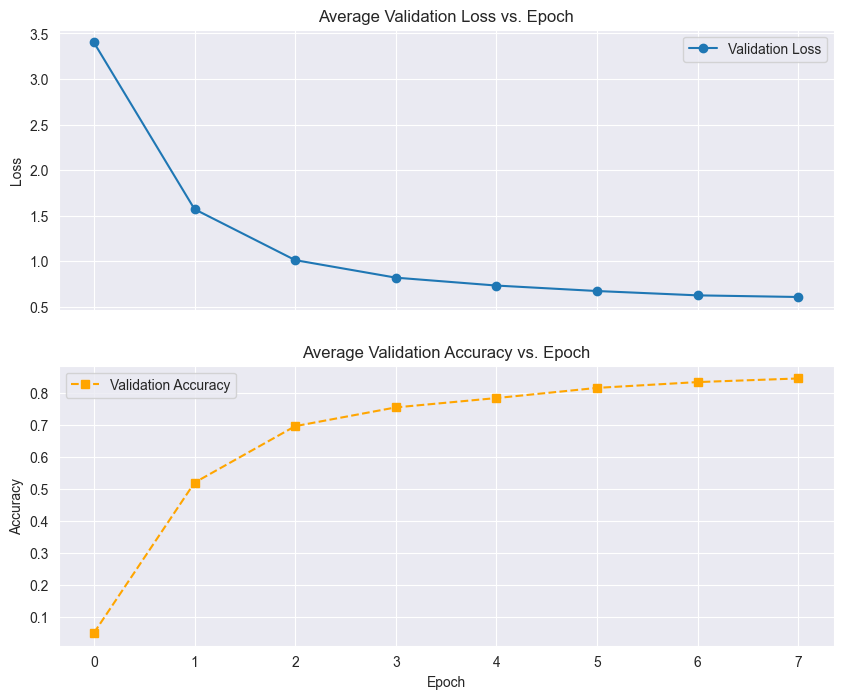

In [12]:
# Assuming you have lists for validation and test losses and accuracies
epochs = range(0,8)

# Create two subplots (one for loss and one for accuracy)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

column_averages_loss = [sum(col) / len(col) for col in zip(*val_loss)]
column_averages_acc = [sum(col) / len(col) for col in zip(*val_accuracy)]

# Plot the training and validation losses
ax1.plot(epochs, column_averages_loss, label='Validation Loss', marker='o', linestyle='-')
ax1.set_ylabel('Loss')
ax1.set_title('Average Validation Loss vs. Epoch')
ax1.legend()

# Plot the training and validation accuracies
ax2.plot(epochs, column_averages_acc, label='Validation Accuracy', marker='s', linestyle='--', color='orange')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Average Validation Accuracy vs. Epoch')
ax2.legend()

plt.show()

In [13]:
from tabulate import tabulate

# Assuming you have test_accuracy and test_loss lists containing values for each fold

fold_num = len(test_accuracy)

# Create a list of lists to store data for the table
table_data = [["Fold", "Test Accuracy", "Test Loss"]]
for i in range(fold_num):
    table_data.append([i+1, test_accuracy[i], test_loss[i]])

# Calculate average test accuracy and test loss
avg_test_accuracy = sum(test_accuracy) / fold_num
avg_test_loss = sum(test_loss) / fold_num

# Add rows for average values
table_data.append(["Average", avg_test_accuracy, avg_test_loss])

# Print the table
print(tabulate(table_data, headers="firstrow", tablefmt="grid"))


+---------+-----------------+-------------+
| Fold    |   Test Accuracy |   Test Loss |
+=========+=================+=============+
| 1       |        0.914047 |    0.442121 |
+---------+-----------------+-------------+
| 2       |        0.863278 |    0.631059 |
+---------+-----------------+-------------+
| 3       |        0.891075 |    0.596603 |
+---------+-----------------+-------------+
| 4       |        0.862338 |    0.58937  |
+---------+-----------------+-------------+
| 5       |        0.847572 |    0.6823   |
+---------+-----------------+-------------+
| Average |        0.875662 |    0.58829  |
+---------+-----------------+-------------+


In [29]:
import random
from torchvision import transforms
from PIL import Image
from torchvision import transforms, datasets, utils as tv_utils

class RandomTurnOffPixels(object):
    def __init__(self, probability=0.1):
        self.probability = probability

    def __call__(self, img):
        if random.random() < self.probability:
            img = img.convert("RGB")  # Convert to RGB if not already
            img_array = img.load()
            width, height = img.size
            num_pixels_to_turn_off = int(self.probability * width * height)
            for _ in range(num_pixels_to_turn_off):
                x = random.randint(0, width - 1)
                y = random.randint(0, height - 1)
                img_array[x, y] = (0, 0, 0)  # Set pixel to black
            return img
        return img

In [30]:
accuracy1 = kf_model.test_accuracy1/kf_model.count_batch_test

In [31]:
print('Accuracy without augmentations:', accuracy1)

Accuracy without augmentations: 0.9079733455882353


In [32]:
kf_model

CNN_ASL(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (linear1): Linear(in_features=160000, out_features=50, bias=True)
  (linear2): Linear(in_features=50, out_features=29, bias=True)
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (train_accuracy): MulticlassAccuracy()
)

In [ ]:
correct_predictions = 0
total_predictions = 0
to_pseudo_rgb = Lambda(lambda x: x.repeat(3, 1, 1))
test_dataloader = DataLoader(datasets.ImageFolder(test_data_path, transform=transform), batch_size=64)
augmentations = [
    transforms.Compose([  
        transforms.ToPILImage(),
        RandomTurnOffPixels(probability=0.2),
        transforms.Grayscale(num_output_channels=3),  # Convert to grayscale with 3 channels
        transforms.ToTensor(),
    ]),

    transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
    ])            

]
x = 0
# Iterate over the test dataset
for images, labels in test_dataloader:        
    # Initialize final predictions
    final_predictions = torch.zeros(len(labels), 29)

    # Iterate for the specified number of prediction runs
    for j in range(2):
        # Perform predictions
        
        aug_index = j % len(augmentations)
        with torch.no_grad():
            aug_images = torch.stack([augmentations[aug_index](image) for image in images])
            preds = kf_model(aug_images)

        # Accumulate predictions
        final_predictions += preds
        if x == 0:
            x += 1
    # Average predictions
    final_predictions /= 2

    # Calculate accuracy
    predicted_labels = torch.argmax(final_predictions, dim=1)
    
    correct_predictions += (predicted_labels == labels).sum().item()
    total_predictions += len(labels)
    
    # Display the augmented images


# Calculate accuracy
accuracy = correct_predictions / total_predictions
print("Accuracy:",accuracy)

In [ ]:
# for model in ensemble_models:
#     model.eval()
#     with torch.no_grad():
#         predictions = []
#         for inputs, labels in test_loader:
#             outputs = model(inputs)
#             predictions.extend(torch.argmax(outputs, dim=1).cpu().tolist())
#     individual_predictions.append(predictions)
# individual_predictions = [[0,1,0,3,2,1],[3,3,2,0,1,5],[3,1,5,2,3,4],[1,2,3,4,5,4]]
# 
# common_predictions = set(individual_predictions[0]).intersection(*individual_predictions[1:])
# 
# # Convert common predictions back to a list if needed
# common_predictions = list(common_predictions)
# 
# print("Common predictions:", common_predictions)

In [ ]:
# import os
# import shutil
# 
# # Define the directory containing the images
# image_dir = 'C:\\Users\\nadav\\Downloads\\Final_Data_Full\\Final_Data_Full\\train'
# 
# # Get a list of all image files in the directory
# image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
# 
# # Iterate over each image file
# for image_file in image_files:
#     # Extract the prefix of the image file name up to the '_' character
#     prefix = image_file.split('_')[0]
#     
#     # Create directory if it doesn't exist
#     target_dir = os.path.join(image_dir, prefix)
#     if not os.path.exists(target_dir):
#         os.makedirs(target_dir)
#     
#     # Move the image file to the corresponding directory
#     src_path = os.path.join(image_dir, image_file)
#     dst_path = os.path.join(target_dir, image_file)
#     shutil.move(src_path, dst_path)
# 
# print("Images moved to appropriate folders.")

In [ ]:
# model = CNN_ASL.load_from_checkpoint("lightning_logs/version_181/checkpoints/epoch=19-step=19580.ckpt",train_data=train_data, val_data=train_val)
# # model = CNN_ASL.load_from_checkpoint("lightning_logs/version_283/checkpoints/epoch=4-step=95.ckpt", train_data=train_data, val_data=train_val)
# # disable randomness, dropout, etc...
# model.eval()